In [1]:
"""
Name: con_measures.ipynb
Authors: Stephan Meighen-Berger, Andrea Turcati
Checks the effect different measures have
"""
%load_ext autoreload
%autoreload 2

In [2]:
 # General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
def Unique(array, orderby='first'):
    array = np.asarray(array)
    order = array.argsort(kind='mergesort')
    array = array[order]
    diff = array[1:] != array[:-1]
    if orderby == 'first':
        diff = np.concatenate([[True], diff])
    elif orderby == 'last':
        diff = np.concatenate([diff, [True]])
    else:
        raise ValueError
    uniq = array[diff]
    index = order[diff]
    return uniq[index.argsort()]

In [6]:
# Module imports
from contagion import Contagion, config
# Options
# General
config['general']['trace spread'] = True
# Population
config['population']['population size'] = 9999
config['population']['social circle pdf']["mean"] = 40
config['population']['social circle interactions pdf']["mean"] = 20
config["population"]['population class'] = 'HomogeneousPopulation'
# HomogeneousPopulation AccuratePopulation
# Infection
config['infection']['infected'] = 1
config['infection']['infection probability pdf']['mean'] = 4.
config['infection']['infection probability pdf']['sd'] = 2.42
config['infection']['infection probability pdf']['max_val'] = 0.15
config['infection']["latency duration pdf"]['mean'] = 2.
config['infection']["latency duration pdf"]['sd'] = 1.0
config['infection']["incubation duration pdf"]['mean'] = 3.
config['infection']["incubation duration pdf"]['sd'] = 0.01
config['infection']["infectious duration pdf"]['mean'] = 2.
config['infection']["infectious duration pdf"]['sd'] = 0.2
config['infection']["hospitalization probability pdf"]['mean'] = 0.5
config['infection']["hospitalization probability pdf"]['sd'] = 0.01
# Measures
config['measures']['type'] = 'contact_tracing'

In [7]:
# Creating a contagion object
fractions = [0., 0.2, 0.5, 0.7]
results = []
results_r_eff = []
number_of_runs = 200
run_ids = []
for fraction in fractions:
    stats_arr = []
    t_s_arr = []
    for seed in tqdm(range(number_of_runs)):
        config['general']["random state seed"] = seed
        config["measures"]["tracked fraction"] = fraction
        contagion = Contagion()
        contagion.sim()
        stats_arr.append(pd.DataFrame(contagion.statistics))
        t_s_arr.append(contagion.trace_infection)
    # Averaging
    stats = {}
    for key in stats_arr[0].keys():
        stats[key] = np.average(np.array([
            stats_arr[i][key]
            for i in range(len(stats_arr))
        ]), axis=0)
    # R_eff_tina
    r_eff_arr_tina = []
    for id_t_s, t_s in enumerate(t_s_arr):
        try:
            lower_id = 0
            edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
            unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
            counter_dic = dict(zip(unique, counts / 2))
            sorted_infectors = Unique(np.hstack(np.array([day[0, :,0] for day in t_s])))
            r_eff_tina_tmp = []
            for i in range(config['general']["simulation length"]):
                newly_recovered = np.diff(stats_arr[id_t_s]['is_recovered'])
                newly_recovered = np.insert(newly_recovered, 0, 0)
                today_recovered = newly_recovered[i]
                upper_id = int(today_recovered + lower_id)
                todays_recovered_infectors = sorted_infectors[lower_id:upper_id]
                these_infected = np.sum(np.array([counter_dic[infec] for infec in todays_recovered_infectors]))
                lower_id = upper_id
                r_eff_tina_tmp.append(these_infected / len(todays_recovered_infectors))
            r_eff_tina_tmp = np.nan_to_num(np.array(r_eff_tina_tmp))
            r_eff_arr_tina.append(r_eff_tina_tmp)
        except:
            r_eff_arr_tina.append(range(config['general']["simulation length"]))
    # Fetching representative result
    maxima_id = np.array([np.argmax(stats_arr[i]['is_infected']) for i in range(len(stats_arr))])
    average_max_id = np.argmax(stats['is_infected'])
    nearest_id = (np.abs(maxima_id - average_max_id)).argmin()
    run_id = nearest_id
    results.append(stats_arr[run_id]['is_infected'])
    results_r_eff.append(r_eff_arr_tina[run_id])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:25<00:00,  5.17s/it]
C:\Users\steph\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\steph\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:03<00:00,  2.18s/it]


In [8]:
# Plotting standards
std_size = 10.
fontsize = 15.
lw=3.
h_length=1.

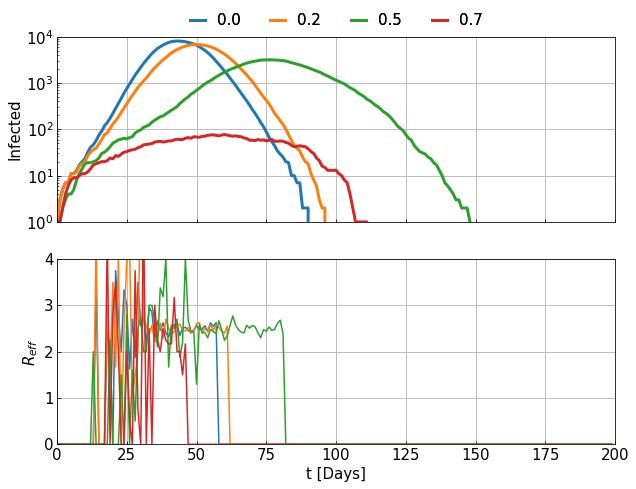

In [9]:
 # Infections per time step
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
for id_frac, fraction in enumerate(fractions):
    ax1.plot(contagion.t, results[id_frac],
             lw=lw, label='%.1f' % fraction)
ax1.set_ylim(1., 1e4)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_ylabel(r'Infected', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=4, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
ax1.grid(True)
for id_frac, fraction in enumerate(fractions):
    ax2.plot(contagion.t, results_r_eff[id_frac],
             lw=lw/2, label='%.1f' % fraction)
ax2.set_xlim(0, 200)
ax2.set_ylim(0., 4.)
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r't [Days]', fontsize=fontsize)
ax2.set_ylabel(r'$R_{eff}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax2.grid(True)
plt.show()

In [10]:
figure.savefig(PICS + "Contagion_Measures.png",
               bbox_inches='tight')